# Emotional Speech Classification using QCi's EmuCore Reservoir Computer

## Introduction

We have used QCi’s EmuCore reservoir technology to classify emotional speech files. What follows is a brief discussion of the dataset, our approach, and some results.

### Reservoir Computing

The idea is to pass data through a randomly initialized neural network and then use the processed data to train a simple linear model downstream, instead of training a full neural netwrok. Reservoir based models are easier to setup and are less expensive to train. Setting up reservoir based models needs less domanin expertise for different applications.

<img src="figures/general_reservoir_schematic.png" alt="fishy" class="bg-primary mb-1" width="400px">

### Recurrent Neural Networks (RNN)

Here we use a Recurrent Neural Networks (RNN) architecture as our reservoir.

https://en.wikipedia.org/wiki/Recurrent_neural_network

<img src="figures/rnn_model.png" alt="fishy" class="bg-primary mb-1" width="500px" >

<img src="figures/rnn_reservoir_schematic.png" alt="fishy" class="bg-primary mb-1" width="500px">

### QCi's EmuCore

QCI's EmuCore technology is based a time delayed scheme.

<img src="figures/time_delayed_reservoir_schematic.png" alt="fishy" class="bg-primary mb-1" width="500px">

https://arxiv.org/pdf/2102.09049.pdf


## Dataset

In this study, we used the RAVDESS Emotional Speech Dataset. RAVDESS
dataset consists of 1440 audio files, generated by 24 speakers, which correspond
to 8 different emotion. The aim is build a model that can detect which emotion
an audio file corresponds to.


https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio


Copy the files to a directory called "ravdess_files" under the working directory.

## Method

Our approach consists of the following steps,

1) Convert each audio file to a time series with an appropriate sampling rate.

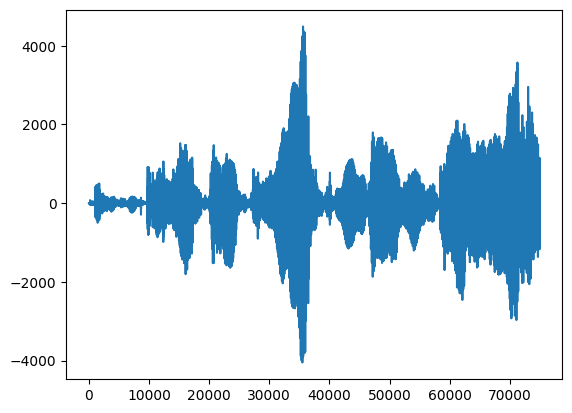

In [81]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

samp_freq, y = wavfile.read("ravdess_files/03-01-05-01-01-02-20.wav")

y = np.array(y, dtype=np.float64)
y = y[50001: 125000]

plt.plot(y)
plt.show()

2) Convert each time series to a chochleagram. A cochleagram is a time-frequency representation of the audio signal and as such is a 2 dimensional array. 

https://en.wikipedia.org/wiki/Computational_auditory_scene_analysis#Cochleagram


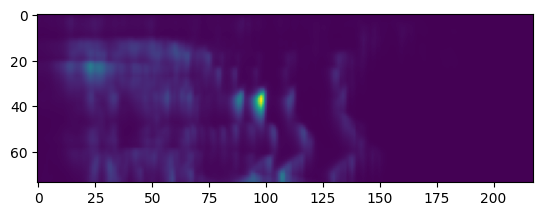

In [68]:
import numpy as np
from lyon.calc import LyonCalc

calc = LyonCalc()

vec = calc.lyon_passive_ear(
    y, 1.0e6, decimation_factor=1000, ear_q=8,
) 

vec = np.array(vec)

plt.imshow(vec)

3) Initialize reservoir (QCi's EmuCore) once and then run each cochleagram through the reservoir and store its transient response.

4) Use the transient responses to build a linear model.

The training and testing data were split such as they contain different sets of speakers.

## Imlementation

### Utility Functions

We define a few utility functions.

In [69]:
import os
from os import listdir
from os.path import isfile, join
import sys
import numpy as np
import librosa
from lyon.calc import LyonCalc
from scipy.io import wavfile


def to_categorical(y, num_classes=None, dtype="float32"):

    y = np.array(y, dtype="int")
    input_shape = y.shape

    # Shrink the last dimension if the shape is (..., 1).
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])

    y = y.reshape(-1)
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def _parse_rescale_arg(rescale):
  """Parse the rescaling argument to a standard form.

  Args:
    rescale ({'normalize', 'standardize', None}): Determines how rescaling
      will be performed.

  Returns:
    (str or None): A valid rescaling argument, for use with wav_to_array or
      similar.

  Raises:
    ValueError: Throws an error if rescale value is unrecognized.
  """
  if rescale is not None:
    rescale = rescale.lower()
  if rescale == 'normalize':
    out_rescale = 'normalize'
  elif rescale == 'standardize':
    out_rescale = 'standardize'
  elif rescale is None:
    out_rescale = None
  else:
    raise ValueError('Unrecognized rescale value: %s' % rescale)
  return out_rescale

def rescale_sound(snd_array, rescale):
  """Rescale the sound with the provided rescaling method (if supported).

  Args:
    snd_array (array): The array containing the sound data.
    rescale ({'standardize', 'normalize', None}): Determines type of
      rescaling to perform. 'standardize' will divide by the max value
      allowed by the numerical precision of the input. 'normalize' will
      rescale to the interval [-1, 1]. None will not perform rescaling (NOTE:
      be careful with this as this can be *very* loud if playedback!).

  Returns:
    array:
    **rescaled_snd**: The sound array after rescaling.
  """
  rescale = _parse_rescale_arg(rescale)
  if rescale == 'standardize':
    if issubclass(snd_array.dtype.type, np.integer):
      snd_array = snd_array / float(np.iinfo(snd_array.dtype).max)  # rescale so max value allowed by precision has value 1
    elif issubclass(snd_array.dtype.type, np.floating):
      snd_array = snd_array / float(np.finfo(snd_array.dtype).max)  # rescale so max value allowed by precision has value 1
    else:
      raise ValueError('rescale is undefined for input type: %s' % snd_array.dtype)
  elif rescale == 'normalize':
    snd_array = snd_array / float(snd_array.max())  # rescale to [-1, 1]
  # do nothing if rescale is None
  return snd_array


def wav_to_array(fn, rescale='standardize'):
  """ Reads wav file data into a numpy array.

    Args:
      fn (str): The file path to .wav file.
      rescale ({'standardize', 'normalize', None}): Determines type of
        rescaling to perform. 'standardize' will divide by the max value
        allowed by the numerical precision of the input. 'normalize' will
        rescale to the interval [-1, 1]. None will not perform rescaling (NOTE:
        be careful with this as this can be *very* loud if playedback!).

    Returns:
      tuple:
        **snd** (int): The sound in the .wav file as a numpy array.
        **samp_freq** (array): Sampling frequency of the input sound.
  """
  samp_freq, snd = wavfile.read(fn)
  snd = rescale_sound(snd, rescale)
  return snd, samp_freq

def search_audio_files(folder_path):
    """Parse the folder for audio files

    Args:
        folder_path ([string]): [parse the path for .wave files]

    Returns:
        [list]: [list of audio file names]
    """   

    file_names = [f for f in listdir(folder_path) if isfile(join(folder_path, f)) and '.wav' in f]
    return file_names


def convert_to_cochleagram(
    audio_path,
    decimation_factor=77,
    n=None,
    nonlinearity=None,
    maxLength=None,
):  
    """
     Creates a spectrogram of a wav file. Cochleagram dimension = Nf(channel)xNt(time steps)
    :param audio_path: path of wav file
    :param n: (int) Number of filters to use in the filterbank.
    :param nonlinearity:    None applies no nonlinearity. 
                            'db' will convert output to decibels (truncated at -60). 
                            'power' will apply 3/10 power compression.
    :return:
        None
    """


    signal,sample_rate = wav_to_array(audio_path)
    
    signal = signal[50001: 125000]
    
    fs=12E3 #resample frequency
    data = librosa.core.resample(y=signal.astype(np.float64), orig_sr=sample_rate, target_sr=fs, res_type="scipy")
        
    # zero padding
    if maxLength is not None and len(data) > maxLength:
       
        err_msg=f"datalenght={len(data)}, maxlength={maxLength},data length cannot exceed padding length."
        print(err_msg)
        # raise ValueError(err_msg)
        return (None,-1)
    elif maxLength is not None and len(data) < maxLength:
        embedded_data = np.zeros(maxLength)
        offset = np.random.randint(low = 0, high = maxLength - len(data))
        embedded_data[offset:offset+len(data)] = data
    elif maxLength is not None and len(data) == maxLength:
        # nothing to do here
        embedded_data = data
        pass
    
    if maxLength is not None:
        data = embedded_data

    calc = LyonCalc()

    #using resampled data
    coch = calc.lyon_passive_ear(
        data, fs, decimation_factor=decimation_factor, ear_q=8,
    ) #, step_factor=0.35)

    coch=np.array(coch)

    return (coch,0)
    
def WSR_MSE(target_lst,est_lst):
    '''
    
    :param target: this is list of targets 
    :param estimate: this is list of estimate
    '''
    
    sucess=0
    count=0
    for estimate,target in zip(est_lst,target_lst):
        estimate_winner=(estimate==np.amax(estimate))*2-1
        count=count+1
        if((estimate_winner==target).all()):
            sucess=sucess+1
    
    wsr=sucess/count
    return wsr

### Build training and testing datasets

This step includes converting each file to a time series and consequently to a cochleagram. As mentioned, the data is split into training and testing such that they correspond to different speakers.

In [70]:
import os
import sys
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

AUDIO_DIR = "ravdess_files/"
NUM_LABELS = 8
NUM_ACTORS = 24
NUM_TRAIN_ACTORS = 19
DECIMATION_FACTOR = 77
MAX_LENGTH = None
ACTORS = [i for i in range(1, NUM_ACTORS + 1)]

We choose a subset of the actors (speakers) as the training set. This way we use files from different speakers in training and testing.

In [65]:
random.shuffle(ACTORS)
train_actors = ACTORS[:NUM_TRAIN_ACTORS]

We then loop through all audio files and convert them to cochleagrams. We also get the label corresponding to each audio files from the name of the file, for both training and testing sets. The results are stored into two binary files.

In [ ]:
audio_files = search_audio_files(AUDIO_DIR)

train_set = {}
test_set = {}
for audio_file in audio_files:
    
    print(audio_file)
    
    base_name = audio_file.split(".")[0]
    tmp_list = base_name.split("-")
    emotion = int(tmp_list[2])                         
    emotion_intensity = tmp_list[3]                           
    statement = tmp_list[4]                                  
    repetition = tmp_list[5]                                  
    actor = int(tmp_list[6])       
    
    cochleagram, status = convert_to_cochleagram(
        os.path.join(AUDIO_DIR, audio_file),
        decimation_factor=DECIMATION_FACTOR,
        maxLength=MAX_LENGTH
    )
    
    if cochleagram is None:                                    
        continue  
        
    label = to_categorical(
        emotion - 1,
        num_classes=NUM_LABELS
    )
    
    if actor in train_actors:                     
        train_set[audio_file] = {
        "coch": cochleagram, "label": label
    }
    else:                                         
        test_set[audio_file] = {"coch": cochleagram, "label": label}
        
np.save("train_set_ravdess.npy", train_set)
np.save("test_set_ravdess.npy", test_set)

Run data through the reservoir.
We should now run the features through QCi's reservoir computer. We start by importing some libraries and setting some parameters.

In [72]:
import os
import numpy as np
from bumblebee_client.bumblebee_client import BumblebeeClient

IP_ADDR = "172.22.19.49"
VBIAS = 0.3
GAIN = 0.65
NUM_NODES = 1000
NUM_TAPS = NUM_NODES
FEATURE_SCALING = 0.5
DENSITY = 1

NUM_F = 77

We should now instantiate a reservoir object,

In [ ]:
client = BumblebeeClient(ip_addr=IP_ADDR)

lock_id, start, end = client.wait_for_lock()
client.reservoir_reset(lock_id=lock_id)
client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

and load the training and testing features and labels,

In [ ]:
train_set = np.load("train_set_ravdess.npy", allow_pickle=True).item()
test_set = np.load("test_set_ravdess.npy", allow_pickle=True).item()

We should now loop through training and testing data and run the features through the reservoir,

In [ ]:
for item in train_set.keys():
    
    print("Train", item)
    assert train_set[item]["coch"].shape[1] == NUM_F

    X_trans_response, _, _ = client.process_all_data(
        input_data=train_set[item]["coch"],
        num_nodes=NUM_NODES,
        density=DENSITY,
        feature_scaling=FEATURE_SCALING,
        lock_id=lock_id,
    )
    
    train_set[item]["coch"] = X_trans_response
    
    assert train_set[item]["coch"].shape[1] == NUM_NODES
    
for item in test_set.keys():
    
    print("Test", item)
    assert test_set[item]["coch"].shape[1] == NUM_F
    
    X_trans_response, _, _ = client.process_all_data(
        input_data=test_set[item]["coch"],
        num_nodes=NUM_NODES,
        density=DENSITY,
        feature_scaling=FEATURE_SCALING,
        lock_id=lock_id,
    )
    
    test_set[item]["coch"] = X_trans_response
    
    assert test_set[item]["coch"].shape[1] == NUM_NODES

And finally store the reservoir output,

In [31]:
np.save("train_set_ravdess_reservoir2.npy", train_set)
np.save("test_set_ravdess_reservoir2.npy", test_set)

## Train a linear Regressor

We now build a linear regression model from the reservoir output. We start by importing libraries, setting parameters, and loading the output of the reservoir,

In [74]:
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

STATEMENTS = ["01", "02"]
INTENSITIES = ["01", "02"]
REPETITIONS = ["01", "02"]

train_set = np.load(
    "train_set_ravdess_reservoir2.npy",
    allow_pickle=True,
).item()

test_set = np.load(
    "test_set_ravdess_reservoir2.npy",
    allow_pickle=True,
).item()



We now loop through training and testing data to assemble the features and labels arrays,

In [75]:
X_train = None
y_train = None
for file_name in train_set.keys():
    base_name = file_name.split(".")[0]
    if base_name.split("-")[5] not in REPETITIONS:
        continue  
    if base_name.split("-")[4] not in STATEMENTS:
        continue  
    if base_name.split("-")[3] not in INTENSITIES:
        continue  
        
    coch = train_set[file_name]["coch"]
    
    if X_train is None:
        X_train = coch
    else:
        X_train = np.concatenate([X_train, coch]) 
        
    label = train_set[file_name]["label"] * 2 - 1       
    labels = np.repeat(label.reshape(-1,1), coch.shape[0], axis=1).T
    
    if y_train is None:
        y_train = labels
    else:
        y_train = np.concatenate([y_train, labels])

We can now train a linear model,

In [76]:
clf = LinearRegression(fit_intercept=True)
clf.fit(X_train, y_train)

LinearRegression()

And we can calculate the success rate of the classifier on both training and testing data,

In [78]:
y_train = []
y_train_prd = []
for file_name in train_set.keys():
    
    base_name = file_name.split(".")[0]
    
    if base_name.split("-")[5] not in REPETITIONS:
        continue
    if base_name.split("-")[4] not in STATEMENTS:
        continue
    if base_name.split("-")[3] not in INTENSITIES:
        continue
        
    X_train_tmp = train_set[file_name]["coch"]
    y_train.append(train_set[file_name]["label"] * 2 - 1)
    y_train_prd.append(clf.predict(X_train_tmp).mean(axis=0))
    
print(
    "Success rate on train data: %0.3f" % (
        WSR_MSE(y_train, y_train_prd)
    )
)

y_test = []
y_test_prd = []
for file_name in test_set.keys():
    base_name = file_name.split(".")[0]       

    if base_name.split("-")[5] not in REPETITIONS:
        continue
    if base_name.split("-")[4] not in STATEMENTS:
        continue
    if base_name.split("-")[3] not in INTENSITIES:
        continue
        
    X_test_tmp = test_set[file_name]["coch"]
    y_test.append(test_set[file_name]["label"] * 2 - 1)
    y_test_prd.append(clf.predict(X_test_tmp).mean(axis=0))
    
print(
    "Success rate on test data: %0.3f" % (
        WSR_MSE(y_test, y_test_prd)
    )
)

Success rate on train data: 0.650
Success rate on test data: 0.373


Several tests were done using different number of reservoir nodes. Some the results are presented here.

<img src="figures/success_rates_table.png" alt="fishy" class="bg-primary mb-1" width="800px"> 
<img src="figures/success_rate_nodes.png" alt="fishy" class="bg-primary mb-1" width="800px"> 